In [1]:
import sys
from glob import glob
from os import path as osp
from datetime import datetime
from tqdm import tqdm
from skimage import io, transform
from matplotlib import pyplot as plt
import numpy as np
from math import sqrt
from statistics import mean
# torch imports
import torch
from torchvision import transforms
from torch.utils.data.dataloader import DataLoader

# root path of project
from os import path as osp
import sys

# get root directory
import re
reg = '^.*/AquaPose'
project_root = re.findall(reg, osp.dirname(osp.abspath(sys.argv[0])))[0]
sys.path.append(project_root)

from lib.dataset.PoseDataset import PoseDataset
from lib.dataset.CycleDataset import CycleDataset

from lib.models.keypoint_rcnn import get_resnet50_pretrained_model

# utils
from lib.utils.slack_notifications import slack_message
from lib.utils.select_gpu import select_best_gpu
from lib.utils.rmsd import kabsch_rmsd, kabsch_rotate, kabsch_weighted_rmsd, centroid, centroid_weighted, rmsd, rmsd_weighted, kabsch

# references import
# source: https://github.com/pytorch/vision/tree/master/references/detection
from references.engine import train_one_epoch, evaluate
from references.utils import collate_fn

from references.transforms import RandomHorizontalFlip

from lib.matching.matching import *
from lib.utils.visual_utils import *

## Load datasets

In [2]:
train_dirs = [osp.join(project_root,'data/vzf/freestyle/freestyle_1'), osp.join(project_root,'data/vzf/freestyle/freestyle_2'), osp.join(project_root,'data/vzf/freestyle/freestyle_3'), osp.join(project_root,'data/vzf/freestyle/freestyle_4')]

test_dirs = [osp.join(project_root,'data/vzf/freestyle/freestyle_5'), osp.join(project_root,'data/vzf/freestyle/freestyle_6')] 

train_datasets = [PoseDataset([dir], train = False, cache_predictions=True) for dir in train_dirs]
test_datasets = [PoseDataset([dir], train = False, cache_predictions=True) for dir in test_dirs]

## Select gpu if available

In [3]:
device = select_best_gpu(min_mem=3000) if torch.cuda.is_available() else torch.device('cpu')
cpu = torch.device('cpu')
print(device)
print(cpu)

cpu
cpu


## Get model and weights

In [4]:
weight_dir = osp.join(project_root, 'weights')
weight_files = glob(osp.join(weight_dir,'*'))
model = get_resnet50_pretrained_model()
for i, f in enumerate(weight_files):
    print('{}, {}'.format(i,f))
model.load_state_dict(torch.load(weight_files[11], map_location=torch.device('cpu')))


0, /mnt/c/Users/Vande/OneDrive - ugentbe/Ingenieurswetenschappen/_master/thesis/AquaPose/weights/6_freestyle_ds_20-03-2020-10-00_epoch39-40.wth
1, /mnt/c/Users/Vande/OneDrive - ugentbe/Ingenieurswetenschappen/_master/thesis/AquaPose/weights/ds_1_2_3_4_25-03-2020-16-48_epoch59-60_min_val_loss_10000.wth
2, /mnt/c/Users/Vande/OneDrive - ugentbe/Ingenieurswetenschappen/_master/thesis/AquaPose/weights/weights_4_box_and_key_predictor.wth
3, /mnt/c/Users/Vande/OneDrive - ugentbe/Ingenieurswetenschappen/_master/thesis/AquaPose/weights/weights_4_epoch.wth
4, /mnt/c/Users/Vande/OneDrive - ugentbe/Ingenieurswetenschappen/_master/thesis/AquaPose/weights/weights_4_finally_fixed.wth
5, /mnt/c/Users/Vande/OneDrive - ugentbe/Ingenieurswetenschappen/_master/thesis/AquaPose/weights/weights_4_finally_fixed_interrupted.wth
6, /mnt/c/Users/Vande/OneDrive - ugentbe/Ingenieurswetenschappen/_master/thesis/AquaPose/weights/weights_4_only_box.wth
7, /mnt/c/Users/Vande/OneDrive - ugentbe/Ingenieurswetenschappen/

<All keys matched successfully>

In [5]:
_ = model.to(device)
_ = model.eval()

## Make prediction for all test datasets and cache results

In [6]:
for ds in test_datasets:
    ds.predict_all(model)

100%|██████████| 19/19 [01:57<00:00,  6.19s/it]


In [8]:
for ds in test_datasets:
    print(ds.num_kp_visible(model))

0%|          | 0/30 [00:00<?, ?it/s]


TypeError: 'list' object is not callable

In [86]:
metric = pck(test_datasets)
metric.num_kp_visible(model)
pck_score = metric.score_per_keypoint(thresholds=[x/100 for x in range(0,55,5)])
inversion_error = metric.inversion_errors(thresholds=[x/100 for x in range(0,55,5)])

100%|██████████| 19/19 [00:00<00:00, 49.00it/s]


In [84]:
class pck:

    def __init__(self, ds_list):
        self.ds_list = ds_list


    # return for prediction and gt the percentage of times it was visible (v=1) and for prediction v==1 and score > min_score
    def num_kp_visible(self, model, min_score = 0):
        # implicitly assume here that all datasets have equal number of joints
        ds = self.ds_list[0]

        res = {}
        res['gt'] = [0] * ds.num_joints
        res['dt'] = [0] * ds.num_joints

        for ds in self.ds_list:
            for idx, (_, target) in enumerate(tqdm(ds)):
                kps = target['keypoints'][0].detach().numpy()

                kps_merged = merge_head(kps)

                # get prediction (use cache)
                _, pred_kps, pred_scores = ds.predict(model, idx)
                pred_kps = merge_head(pred_kps)
                pred_scores = merge_head(pred_scores)

                for joint in range(0,13):
                    # if visible
                    if kps_merged[joint][2] > 0:
                        res['gt'][joint] += 1

                    
                        # if minimum score reached
                        if pred_scores[joint] >= min_score:
                            res['dt'][joint] += 1
        return res


    def score_per_keypoint(self, thresholds=[0.1, 0.2, 0.3, 0.4, 0.5], min_score = - float('inf'), include_occluded=True):
        ds = self.ds_list[0]

        # keep track of how many were visible
        num_visible = [0] * ds.num_joints

        # init results for each joint, for each treshold
        res = [[0 for t in thresholds] for i in range(0,ds.num_joints)]

        for ds in self.ds_list:
            for idx, (_, target) in enumerate(tqdm(ds)):

                # get gt 
                gt_kps = target['keypoints'][0].detach().numpy()
                gt_kps = merge_head(gt_kps)

                # get dt
                _, pred_kps, pred_scores = ds.predict(model, idx)
                dt_kps = merge_head(pred_kps)
                dt_scores = merge_head(pred_scores)

                # get torso diameter
                torso_dist = sqrt((gt_kps[1][0] - gt_kps[9][0])**2 + (gt_kps[1][1] - gt_kps[9][1])**2)
                # if not then use torso from previous iteration, should be fine

                # for every joint
                for joint in range(0,ds.num_joints):
                    if ((include_occluded and gt_kps[joint][2] >= 0) or (gt_kps[joint][2] > 0)) and dt_scores[joint] > min_score:
                        
                        num_visible[joint] += 1

                        # get distance between dt and gt
                        dist = sqrt((gt_kps[joint][0] - dt_kps[joint][0])**2 + (gt_kps[joint][1] - dt_kps[joint][1])**2)

                        for t_id, threshold in enumerate(thresholds):
                            if dist < threshold * torso_dist:
                                res[joint][t_id] += 1

        return [[num / num_visible[joint] for num in res[joint]] for joint in range(0,13)]
    
    def inversion_errors(self, thresholds=[0.1, 0.2, 0.3, 0.4, 0.5], inversion_pairs=[[1,2] , [3,4] , [5,6], [7,8] , [8,9], [10,11] , [11,12]], min_score = - float('inf')):
        ds = self.ds_list[0]

        # keep track of how many were visible
        num_visible = [0] * ds.num_joints

        # init results for each joint, for each treshold
        res = [[0 for t in thresholds] for i in range(0,ds.num_joints)]

        for ds in self.ds_list:
            for idx, (_, target) in enumerate(tqdm(ds)):

                # get gt 
                gt_kps = target['keypoints'][0].detach().numpy()
                gt_kps = merge_head(gt_kps)

                # get dt
                _, pred_kps, pred_scores = ds.predict(model, idx)
                dt_kps = merge_head(pred_kps)
                dt_scores = merge_head(pred_scores)

                # get torso diameter
                torso_dist = sqrt((gt_kps[1][0] - gt_kps[9][0])**2 + (gt_kps[1][1] - gt_kps[9][1])**2)
                # if not then use torso from previous iteration, should be fine

                # for every joint that 
                for joint in range(1,ds.num_joints):
                    if dt_scores[joint] > min_score:

                        # get sibling joint
                        for pair in inversion_pairs:
                            if joint in pair:
                                # first in pair is always odd so sibling is found modulo 2
                                sibling_joint = pair[joint % 2]
                                break

                        num_visible[joint] += 1

                        # get distance between dt and gt
                        dist = sqrt((gt_kps[joint][0] - dt_kps[joint][0])**2 + (gt_kps[joint][1] - dt_kps[joint][1])**2)

                        # get distance between dt and gt of sibling joint
                        dist_sibling = sqrt((gt_kps[sibling_joint][0] - dt_kps[joint][0])**2 + (gt_kps[sibling_joint][1] - dt_kps[joint][1])**2)


                        for t_id, threshold in enumerate(thresholds):
                            if dist > threshold * torso_dist and dist_sibling < threshold * torso_dist:
                                res[joint][t_id] += 1
        
        # avoid division by zero exception
        num_visible[0] = 1
        return [[num / num_visible[joint] for num in res[joint]] for joint in range(0,13)]




## PCK (percentage correct)

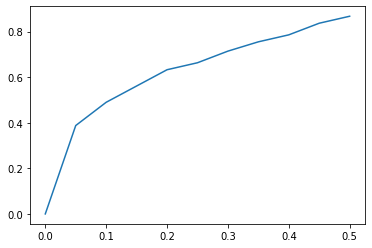

In [96]:
thresholds=[x/100 for x in range(0,55,5)]
for joint in range(11,13,2):
    plt.plot([x for x in thresholds], 0.5 * np.array([s for s in pck_score[joint]]) + 0.5 * np.array([s for s in pck_score[joint +1]]), label=joint)


## Inversion PCK error

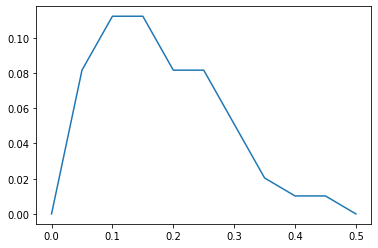

In [97]:
thresholds=[x/100 for x in range(0,55,5)]
for joint in range(11,13,2):
    plt.plot([x for x in thresholds], 0.5 * np.array([s for s in inversion_error[joint]]) + 0.5 * np.array([s for s in inversion_error[joint +1]]), label=joint)
